# Защита модели от Adversarial примеров

Работа выполнена студентом БИБ233 МИЭМ НИУ ВШЭ Коноваловым Матвеем.

Данная работа является продолжением предыдущей, в которой рассматривалось создание Adversarial примеров в задаче классификации изображений.

Атака оказалась крайне удачной, и в ходе данной работы будут рассмотрены способы это исправить.

## Основные способы защиты, рассмотренные в работе:
- Adversarial training
- нормализация входных данных

Все эти изменения будут вноситься при помощи библиотеки Adversarial Robustness Toolbox.

## Подготовка
Зададим все необходимые параметры. В MODEL_PATH укажите, куда вы положили [обученную модель из предыдущего пункта](https://disk.360.yandex.ru/d/r-5SqYBdwTfuuQ)

In [40]:
import torch
import numpy as np
import random
from pathlib import Path

IMG_SIZE = 224
MODEL_PATH = Path('models/best.pt')
DATA_DIR = Path("datasets/svhn_cls")
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 128
SHUFFLE_DS = True
EPS = 8/255
EPS_STEP = 2/255
PGD_STEPS = 6
SEED = 17
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

В качестве первого метода защиты добавим нормализацию входов в модель. Это уже должно будет снизить эффективность Adv. примеров, поскольку они существенно отличаются от нормальных примеров.

In [15]:
from torchvision import transforms

train_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

Загрузим модель. Эксперименты показали, что при такой организации, обучение модели с нуля показывает себя эффективнее дообучения. Больше информации и других экспериментах будет представлено в конце.

In [16]:
class YoloClsAdapter(torch.nn.Module):
    def __init__(self, core_model):
        super().__init__()
        self.core = core_model

    def forward(self, x):
        y = self.core(x)
        if isinstance(y, (tuple, list)):
            y = y[-1]
        return y

In [33]:
from ultralytics import YOLO
from art.estimators.classification import PyTorchClassifier

yolo  = YOLO('yolov8s-cls.pt')
for p in yolo.model.parameters():
    p.requires_grad_(True)
adapter = YoloClsAdapter(yolo.model).to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    adapter.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

classifier = PyTorchClassifier(
    model=adapter,
    loss=loss,
    optimizer=optimizer,
    nb_classes=10,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    device_type=device
)

Считаем обучающую и валидационную выборки.

Обучающая выборка представляется в виде DataGenerator, поскольку целиком в оперативную память она не поместится, а вот валидационную в виду малого размера с целью ускорения можно загрузить целиком.

In [20]:
from art.data_generators import PyTorchDataGenerator
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(root=DATA_DIR / "train",
                       transform=train_tf)
train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=SHUFFLE_DS,
                          num_workers=4,
                          pin_memory=True)
train_gen = PyTorchDataGenerator(iterator=train_loader,
                                 size=len(train_ds),
                                 batch_size=BATCH_SIZE)

In [21]:
from PIL import Image
from art.attacks.evasion import FastGradientMethod

val_samples = 500
all_files = list((DATA_DIR / 'test').glob("*/*.png"))
assert all_files, f"Ничего не найдено в {DATA_DIR}"

idx_files = random.sample(all_files, val_samples)

val_x, val_y = [], []
for fp in idx_files:
    img = Image.open(fp).convert("RGB")
    arr = yolo.model.transforms(img)
    val_x.append(arr)
    val_y.append(int(fp.parent.name))

val_x = np.stack(val_x, axis=0)
val_y = np.asarray(val_y)

Отдельно сгенерируем валидационную adversarial выборку, чтобы прямо во время обучения мы могли следить за качеством на обоих вариантах выборок.

Обратим внимание, что для генерации adv. примеров требуется обученная модель, возьмём её из предыдущей работы

In [7]:
clean_yolo  = YOLO(MODEL_PATH)
clean_adapter = YoloClsAdapter(yolo.model).to(device)

clean_loss = torch.nn.CrossEntropyLoss()
clean_optimizer = torch.optim.AdamW(
    adapter.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

clean_classifier = PyTorchClassifier(
    model=adapter,
    loss=loss,
    optimizer=optimizer,
    nb_classes=10,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    device_type=device
)

attack = FastGradientMethod(estimator=clean_classifier, eps=EPS)
x_adv  = attack.generate(x=val_x)

## Обучение
Наконец можем перейти к обучению. Опять же, эксперименты показали, что при текущей кофигурации, наилучшего качества можно добиться при всего 5 эпохах.

Скорее всего, настолько малое количество требуемых эпох обусловлено относительной простотой задачи, малым размером картинок и достаточно большой обучающей выборкой (72000 примеров в данном случае это достаточно много, причем за счёт генерации adv. примеров получается около 100000 примеров за эпоху).

Отдельно рассмотрим параметры adversarial обучения:
- epsilon = 8/255, это стандартное значение, которое, в том числе, использовалось в предыдущей работе и показало лучшее соотношение эффективности и незаметности
- ration = 0.3 - в первую очередь модель должна показывать хорошие показатели на нормальных примерах, и уже во вторую идет защита от атак. Значение в 0.3 показывает хорошее соотношение clean и adversarial accuracy, которые будут продемонстрированы далее

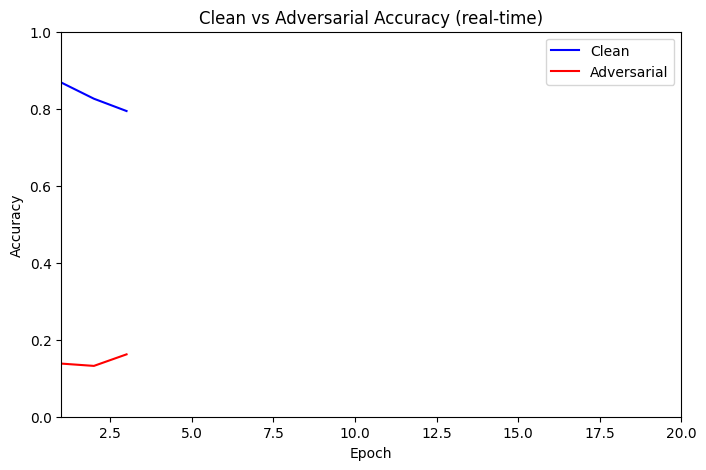

Epochs:  15%|█▌        | 3/20 [18:20<1:44:30, 368.84s/it]

Precompute adversarial examples.:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 3/20 [21:21<2:01:00, 427.10s/it]


KeyboardInterrupt: 

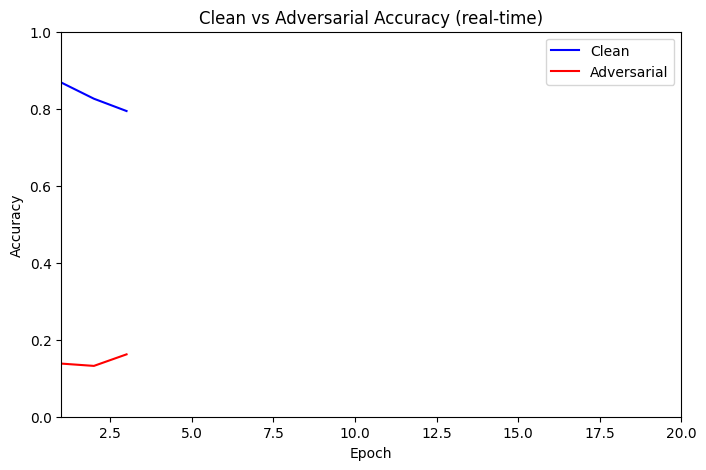

In [45]:
from tqdm import tqdm
from IPython.core.display_functions import clear_output
from matplotlib import pyplot as plt
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(
    estimator=classifier,
    eps=EPS,
    norm=np.inf
)

adv_trainer = AdversarialTrainer(
    classifier=classifier,
    attacks=attack,
    ratio=0.5,
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim(1, EPOCHS)
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Clean vs Adversarial Accuracy (real-time)')
line_clean, = ax.plot([], [], label='Clean', color='blue')
line_adv,   = ax.plot([], [], label='Adversarial', color='red')
ax.legend()
display(fig)

clean_accs = []
adv_accs = []

best_f = 0.0
for epoch in tqdm(range(1, EPOCHS + 1), desc='Epochs'):
    adv_trainer.fit_generator(train_gen, nb_epochs=1)

    preds_clean = adv_trainer.predict(val_x)
    acc_clean = np.mean(np.argmax(preds_clean, axis=1) == val_y)
    preds_adv = adv_trainer.predict(x_adv)
    acc_adv = np.mean(np.argmax(preds_adv, axis=1) == val_y)

    F = 2 * acc_clean * acc_adv / (acc_clean + acc_adv)
    display(f'[EPOCH {epoch}] Clean_acc: {acc_clean:.2f}. Adv_acc: {acc_adv:.2f}. F: {F:.2f}')
    if F >= best_f:
        rob_clas = adv_trainer.get_classifier()
        rob_clas.save('best_robust_classifier.pt', 'models')

    x_epochs = list(range(1, epoch + 1))
    clean_accs.append(acc_clean)
    adv_accs.append(acc_adv)
    line_clean.set_data(x_epochs, clean_accs)
    line_adv.set_data(x_epochs, adv_accs)

    clear_output()
    display(fig)

robust_classifier = adv_trainer.get_classifier()
robust_classifier.save('robust_classifier8.pt', 'models')

## Тестирование обученной модели

In [40]:
data = torch.load('models/robust_classifier2.pt.model')
data.keys

<function OrderedDict.keys>

In [53]:
from ultralytics import YOLO
import torch

yolo = YOLO(MODEL_PATH)
adapter = YoloClsAdapter(yolo.model).to(device)
adapter.load_state_dict(torch.load('models/robust_classifier2.pt.model'))
robust_classifier = PyTorchClassifier(
    model=adapter,
    loss=torch.nn.CrossEntropyLoss(),
    nb_classes=10,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    clip_values=(0.0, 1.0),
    device_type=device
)

Теперь сравним качество изначальной и дообученной моделей как на чистой, так и на adv. выборках

In [29]:
from art.estimators.classification import PyTorchClassifier

basic_yolo  = YOLO(MODEL_PATH)
adapter = YoloClsAdapter(basic_yolo.model).to(device).eval()

loss = torch.nn.CrossEntropyLoss()

basic_cls = PyTorchClassifier(
    model=adapter,
    loss=loss,
    nb_classes=10,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    clip_values=(0.0, 1.0),
    device_type=device
)

In [30]:
from PIL import Image

N_SAMPLES = 1000

all_files = list((DATA_DIR / 'test').glob("*/*.png"))
assert all_files, f"Ничего не найдено в {DATA_DIR}"

idx_files = random.sample(all_files, N_SAMPLES) # Выбираем N_SAMPLES картинок

x, y = [], []
for fp in idx_files:
    img = Image.open(fp).convert("RGB")
    arr = basic_yolo.model.transforms(img)
    x.append(arr)
    y.append(int(fp.parent.name))

clean_x = np.stack(x, axis=0)
clean_y = np.asarray(y)
clean_y

array([9, 0, 3, 1, 2, 2, 7, 3, 9, 1, 1, 6, 2, 6, 7, 4, 2, 8, 9, 8, 7, 7, 1, 5, 3, 4, 0, 6, 2, 1, 2, 1, 0, 6, 8, 1, 4, 1, 2, 4, 3, 2, 6, 4, 4, 4, 1, 7, 1, 1, 0, 1, 1, 3, 3, 9, 4, 1, 6, 3, 2, 4, 2, 6, 6, 5, 2, 2, 4, 1, 7, 3, 2, 4, 3, 2, 2, 1, 0, 6, 2, 5, 5, 0, 1, 4, 4, 5, 0, 3, 4, 0, 7, 1, 5, 2, 2, 2, 5, 2, 6, 9, 3, 6,
       9, 5, 2, 4, 4, 2, 2, 3, 1, 2, 0, 7, 5, 0, 3, 4, 6, 8, 2, 2, 4, 7, 2, 3, 2, 2, 1, 4, 1, 2, 2, 5, 2, 1, 2, 6, 5, 4, 6, 6, 2, 1, 9, 8, 5, 2, 8, 3, 1, 4, 0, 5, 8, 7, 1, 3, 0, 3, 7, 4, 1, 0, 2, 7, 9, 2, 0, 3, 4, 4, 6, 8, 6, 0, 4, 5, 4, 7, 4, 8, 1, 2, 2, 7, 2, 0, 4, 1, 7, 5, 3, 3, 8, 3, 6, 6, 9, 3, 2, 1, 1, 7, 6, 4,
       0, 2, 2, 2, 1, 1, 2, 0, 1, 1, 5, 4, 3, 0, 3, 2, 4, 1, 2, 2, 8, 0, 1, 5, 6, 1, 1, 1, 1, 1, 4, 1, 1, 3, 3, 3, 3, 9, 0, 0, 3, 6, 7, 7, 6, 7, 1, 5, 6, 3, 9, 6, 2, 2, 6, 1, 2, 8, 4, 3, 1, 4, 8, 5, 8, 5, 8, 2, 3, 1, 4, 9, 1, 1, 3, 2, 1, 7, 6, 2, 2, 7, 9, 5, 0, 7, 0, 4, 5, 3, 1, 1, 2, 2, 7, 4, 3, 1, 8, 1, 9, 5, 0, 9,
       5, 7, 4, 2, 6, 1, 1, 1, 4, 8, 8, 2, 

In [36]:
from art.attacks.evasion import FastGradientMethod

EPS = 8/255

# Генерируем FGSM по изначальной модели
basic_fgsm = FastGradientMethod(estimator=basic_cls, eps=EPS)
basic_x_fgsm  = basic_fgsm.generate(x=clean_x)

# FGSM по защищённой модели
robust_fgsm = FastGradientMethod(estimator=robust_classifier, eps=EPS)
robust_x_fgsm  = basic_fgsm.generate(x=clean_x)

In [102]:
train_gen = ChunkedGenerator(
    DATA_DIR / "test",
    chunk=1000,
    batch_size=1000,
    shuffle=False,
)
x, y = train_gen.get_batch()

In [39]:
from sklearn.metrics import accuracy_score

accuracy_score(val_y, adv_trainer.predict(x_adv).argmax(1))

0.138

In [121]:
import pandas as pd

# ❶ Cводим всё в словари --------------------------------------------------------
tests   = dict(  # порядок сохранится как объявлен
    clean_train   = clean_x,
    basic_x_fgsm  = basic_x_fgsm,
    robust_x_fgsm = robust_x_fgsm
)
models  = dict(basic = basic_cls, robust = robust_classifier)

# ❷ Предсказания всех (model × test) за один проход ----------------------------
preds = {
    (m, t): mdl.predict(x).argmax(1)          # argmax → метки классов
    for m, mdl in models.items()
    for t, x   in tests.items()
}

cols = ["basic_accuracy", "basic_ASR", "robust_accuracy", "robust_ASR"]
df = pd.DataFrame(index=tests, columns=cols, dtype="float32")

for m in models:
    clean_pred = preds[(m, "clean_train")]
    acc_col = f"{m}_accuracy"
    asr_col = f"{m}_ASR"

    for t in tests:
        adv_pred = preds[(m, t)]
        accuracy = np.mean(adv_pred == clean_y)
        if t == "clean_train":
            asr = 0
        else:
            asr = np.mean((clean_pred == clean_y) & (adv_pred != clean_y))

        df.at[t, acc_col] = accuracy
        df.at[t, asr_col] = asr

df

C:\Users\ok__\AppData\Local\Temp\ipykernel_19856\1630435535.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.973' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[t, acc_col] = accuracy
C:\Users\ok__\AppData\Local\Temp\ipykernel_19856\1630435535.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.804' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[t, asr_col] = asr
C:\Users\ok__\AppData\Local\Temp\ipykernel_19856\1630435535.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.191' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[t, acc_col] = accuracy


,basic_accuracy,basic_ASR,robust_accuracy,robust_ASR
clean_train,0.973,0.000,0.191,0.0
basic_x_fgsm,0.172,0.804,0.191,0.0
robust_x_fgsm,0.172,0.804,0.191,0.0
